# Getting started with Perceval

In this notebook, we aim to reproduce the $\mathsf{CNOT}$ Gate to 
evaluate its performance while demonstrating key features of Perceval. We use as basis the implementation from [1].

In [1]:
import perceval as pcvl
import sympy as sp
import numpy as np

### Ralph CNOT Gate

We start by describing the circuit as defined by the paper above- it is a circuit on six modes (labelled from 0 to 5 from top to bottom) consisting of five beam splitters. Modes 1 and 2 contain the control system while modes 3 and 4 encode the target system. Modes 0 and 5 are unoccupied ancillary modes.

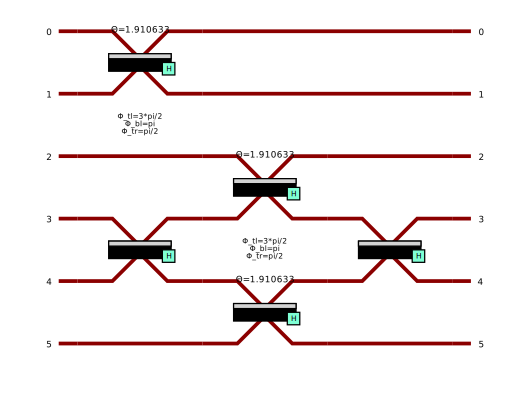

In [2]:
cnot = pcvl.Circuit(6, name="Ralph CNOT")
cnot.add((0, 1), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((3, 4), pcvl.BS.H())
cnot.add((2, 3), pcvl.BS.H(pcvl.BS.r_to_theta(1/3), phi_tl = -np.pi/2, phi_bl = np.pi, phi_tr = np.pi / 2))
cnot.add((4, 5), pcvl.BS.H(pcvl.BS.r_to_theta(1/3)))
cnot.add((3, 4), pcvl.BS.H())
pcvl.pdisplay(cnot)

We can then simulate this circuit using the `Naive` backend on four different input states corresponding to the two-qubit computational basis states. We use `Analyzer` to analyse the performance of the gate. Using heralds, we can get a better visualisation of what the circuit actually does.

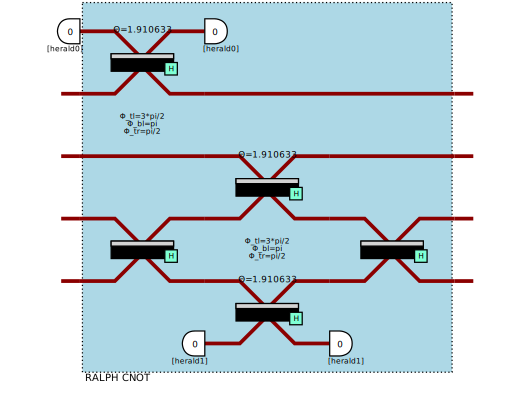

In [3]:
p = pcvl.Processor("Naive", cnot)
p.set_postselection(pcvl.PostSelect("[1,2]==1 & [3,4]==1"))
p.add_herald(0, 0)
p.add_herald(5, 0)

pcvl.pdisplay(p, recursive=True)

In [4]:
states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"00": "00", "01": "01", "10": "11", "11": "10"})
pcvl.pdisplay(ca)
print("performance=%s, fidelity=%.3f%%" % (pcvl.simple_float(ca.performance)[1], ca.fidelity * 100))

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance=1/9, fidelity=100.000%


Beyond the actual logic function, what is interesting with this gate us that it produces entangled states that we will be trying to check with CHSH experiment when the source is not perfect.

### Checking for entanglement with CHSH experiment
![https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Two_channel_bell_test.svg/1340px-Two_channel_bell_test.svg.png)
*https://en.wikipedia.org/wiki/File:Two_channel_bell_test.svg*

To reproduce this Bell test protocol, we define a new circuit which uses the $\mathsf{CNOT}$ gate implemented above as a sub-circuit. The parameters $a$ and $b$ describe the measurement bases used by players $A$ and $B$ in the runs of the Bell-test. We define a photon source with a brightness of 40% and a purity of 99% that will be used by the `Processor`.

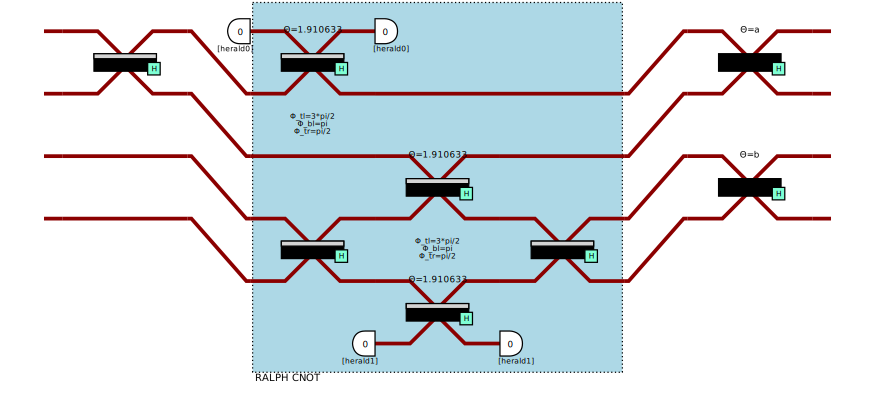

In [5]:
source = pcvl.Source(emission_probability=0.40, multiphoton_component=0.01)

QPU = pcvl.Processor("SLOS", 4, source)
QPU.add(0, pcvl.BS.H())

# Remove postprocess function as it would mean nothing to the new QPU
p.clear_postselection()

QPU.add(0, p)

a = pcvl.Parameter("a")
b = pcvl.Parameter("b")

QPU.add(0, pcvl.BS.H(theta=a))
QPU.add(2, pcvl.BS.H(theta=b))

pcvl.pdisplay(QPU, recursive=True)

We start by setting the values of the two parameters to 0, meaning that the beam splitters after the $\mathsf{CNOT}$ effectively act as the identity. 

In [6]:
a.set_value(0)
b.set_value(0)

We now state that our photons will be inputted on ports 1 and 2 (using the 0-index convention, and not counting heralded modes).

In [7]:
QPU.with_input(pcvl.BasicState([0, 1, 1, 0]))

We now detail the different state vectors that are the probabilistic inputs to the circuit. The most frequent input is the empty state, followed by two states with only a single photon on either of the input ports, then by the expected nominal input $|0,1,1,0,0,0\rangle$. Here, the heralded modes are shown because if there were a photon on them, they would also have the imperfect source. They are represented at the end of the state (the two last modes) as they have been added after the declaration of the processor.

In [8]:
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

state,probability
"|0,0,0,0,0,0>",9/25
"|0,0,{_:0},0,0,0>",0.2395
"|0,{_:0},0,0,0,0>",0.2395
"|0,{_:0},{_:0},0,0,0>",0.1594
"|0,0,{_:0}{_:1},0,0,0>",4.8193e-4
"|0,{_:0}{_:1},0,0,0,0>",4.8193e-4
"|0,{_:0}{_:1},{_:0},0,0,0>",3.2064e-4
"|0,{_:0},{_:0}{_:1},0,0,0>",3.2064e-4
"|0,{_:0}{_:1},{_:0}{_:2},0,0,0>",0


We can then check the output state distribution corresponding to this input distribution. By default, since our input state had 2 photons, only states having at least 2 detected photons are kept. This can be changed using `min_detected_photons_filter`.

In [12]:
output_distribution=QPU.probs()["results"]
pcvl.pdisplay(output_distribution, max_v=10)

state,probability
"|0,2,0,0>",0.249215
"|0,0,1,1>",0.248061
"|1,1,0,0>",0.124184
"|0,1,0,1>",0.106421
"|1,0,1,0>",0.105829
"|0,0,0,2>",0.06284
"|0,0,2,0>",0.062804
"|0,1,1,0>",0.01921
"|1,0,0,1>",0.018654
"|0,3,0,0>",0.00041751


Let us run now the experiment with increasing value of g2 in the range $[0, 0.2]$ with a brightness of $0.15$ and check the CHSH inequality.

In [10]:
from tqdm.auto import tqdm
x = np.arange(0, 20, 0.5)
y = []

for g2 in tqdm(x):
    Es = []
    for va in [0, sp.pi/2]:
        a.set_value(va)
        for vb in [sp.pi/4, 3*sp.pi/4]:
            b.set_value(vb)
            Npp, Npm, Nmp, Nmm = 0, 0, 0, 0
            source = pcvl.Source(emission_probability=.1, multiphoton_component=g2/100)
            QPU2 = pcvl.Processor("SLOS", 4, source)
            # Only the source of the big QPU remains
            QPU2.add(0, QPU)
            QPU2.with_input(pcvl.BasicState([0, 1, 1, 0]))
            # we add a post-selection on the processor, there needs to be exactly one photon in mode 0,1 and one in mode 2,3
            QPU2.set_postselection(pcvl.PostSelect("[0,1]==1 & [2,3]==1"))
            output_distribution=QPU2.probs()["results"]
            for output_bs, prob in output_distribution.items():
                output_state = output_bs
                if (output_state[0] == 1 and output_state[2] == 1):
                    Npp = prob
                if (output_state[0] == 1 and output_state[3] == 1):
                    Npm = prob
                if (output_state[1] == 1 and output_state[2] == 1):
                    Nmp = prob
                if (output_state[1] == 1 and output_state[3] == 1):
                    Nmm = prob
            E = (Npp-Npm-Nmp+Nmm)/(Npp+Npm+Nmp+Nmm)
            Es.append(E)

    S = Es[0]-Es[1]+Es[2]+Es[3]
    print("g2=",g2/100, "S=", S)
    y.append(S)

  0%|          | 0/40 [00:00<?, ?it/s]

g2= 0.0 S= 2.82842712474619
g2= 0.005 S= 2.798925086897082
g2= 0.01 S= 2.7697755721269917
g2= 0.015 S= 2.740972299430207
g2= 0.02 S= 2.7125091361893583
g2= 0.025 S= 2.684380093709375
g2= 0.03 S= 2.6565793231225863
g2= 0.035 S= 2.629101111249713
g2= 0.04 S= 2.601939876739589
g2= 0.045 S= 2.5750901662563264
g2= 0.05 S= 2.548546650864069
g2= 0.055 S= 2.522304122459081
g2= 0.06 S= 2.4963574904030104
g2= 0.065 S= 2.47070177819886
g2= 0.07 S= 2.4453321203336804
g2= 0.075 S= 2.420243759182643
g2= 0.08 S= 2.395432042049169
g2= 0.085 S= 2.3708924182796363
g2= 0.09 S= 2.3466204364874614
g2= 0.095 S= 2.3226117418512207
g2= 0.1 S= 2.2988620735262764
g2= 0.105 S= 2.275367262102807
g2= 0.11 S= 2.2521232271872895
g2= 0.115 S= 2.2291259750229884
g2= 0.12 S= 2.206371596211099
g2= 0.125 S= 2.1838562634922076
g2= 0.13 S= 2.1615762296041026
g2= 0.135 S= 2.1395278251963994
g2= 0.14 S= 2.1177074568222007
g2= 0.145 S= 2.096111604979523
g2= 0.15 S= 2.0747368222259714
g2= 0.155 S= 2.053579731336087
g2= 0.16 S=

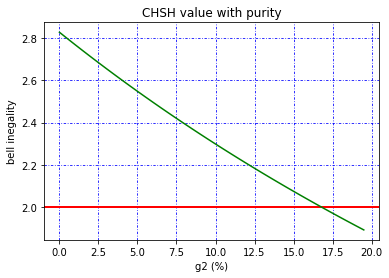

In [11]:
import matplotlib.pyplot as plt
plt.title("CHSH value with purity")
plt.xlabel("g2 (%)")
plt.ylabel("bell inegality")
plt.axhline(y=2, linewidth=2, color="red", label= 'horizontal-line')
plt.plot(x, y, color ="green")
plt.grid(color='b', dashes=(3, 2, 1, 2))
plt.show()

Beyond 17% of g2, we are crossing the value $2$, i.e. not violating anymore the $|CHSH|\le 2$ inegality!

## Reference

> [1] T. C. Ralph, N. K. Langford, T. B. Bell, and A. G. White. Linear optical controlled-NOT gate in the coincidence basis. [Physical Review A](https://link.aps.org/doi/10.1103/PhysRevA.65.062324), 65(6):062324, June 2002. Publisher: American Physical Society.